# Control Scenario Specifications
https://app.box.com/file/574163728766
    

### Start year:
2020 (or year 0)

### Duration:
80 years

### Existing Fleet:
96 Reactors

### Energy projection / demand:
-1% / year (~2050)

+1.7% / year (2050~2090)

0% / year (2090-)


### Reactor profile:
2021 - Vogtle 3 and 4 (AP1000), Nuscale SMRs (300MWe)

All LWRs modeled as SMRs

2040, 2045 advanced reactor prototypes

By 2050, 10% of new reactors are advanced


### Recycling
Recycle anything generated after 2020

Continuous U/TRU recycle

Assume all LWRs use LEU


### Manual deployments (Power MWe)
2021 Vogtle (1250)

2022 Vogtle2 (1250)

2026 Utah AMPS (50)

2027 Utah AMPS (550)

2040 SFR (400)

2045 SFR (400)

2050 SFR to meet demand

# ========================

# Power demand equations

96*(0.99**(t/12))


time: 359		demand: 71.070735
71.07073465522431*(1.017)**((t-359)/12)


time: 839		demand: 139.485454
139.48545443020868


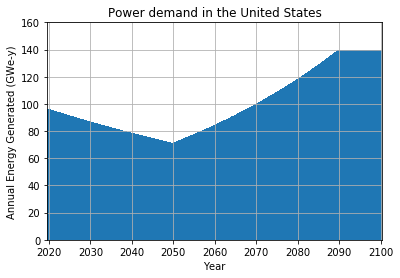

In [31]:

# energy demand plot for GUI
import numpy as np
import matplotlib.pyplot as plt
timesteps = np.array(range(960))
years = 2020 + timesteps/12
demand = np.zeros(len(timesteps))
# assuming initial capacity of 96GWe
eq1 = '96*(0.99**(t/12))'
print(eq1)
print('\n')

demand[:360] = [eval(eq1) for t in timesteps[:360]]
d1 = demand[359]
t1 = timesteps[359]
print('time: %i\t\tdemand: %f' %(t1, d1))
eq2 = '%s*(1.017)**((t-%s)/12)' %(d1, t1)
print(eq2)
print('\n')
demand[360:360+480] = [eval(eq2) for t in timesteps[360:360+480]]
d2 = demand[360+479]
t2 = timesteps[360+479]
print('time: %i\t\tdemand: %f' %(t2, d2))
eq3 = str(d2)
print(eq3)
demand[360+480:] = [d2]
plt.bar(years, demand)
plt.xlabel('Year')
plt.title('Power demand in the United States')
plt.grid()
plt.ylabel('Annual Energy Generated (GWe-y)')
plt.ylim(0, 160)
plt.margins(x=0, y=0)


# Legacy Reactor specification

Reactors are largely separated to two types: PWRs and BWRs.
The reactors are `linearly scaled`, meaning that the number of assemblies
in the reactor are linearly scaled with power capacity, from a model reactor.

The following parameters are the same for BWR and PWR:

cycle time: 18 months

refueling time: 2 months

discharge burnup: 45 GWthd/MTHM

## BWR:

Assembly mass: 180 kg

assemblies per core: 764 per 1000 MWe

## PWR:

assembly mass: 446 kg

assemblies per core: 193 per 1000 MWe




# ========================

# Small Modular Reactor Specification
https://www.nrc.gov/docs/ML1924/ML19241A412.pdf

## Power
50Mwe (160MWth)

## Operation
LEU enrichments = 4.95%

fuel average temperature 900k

mass per assembly: ~249.76 kgs (549.98 lbs)

37 assemblies in a core

Gd in fuel (3%) - it says up to 8% in the manual

3 batch

24 month cycle

Burnup ~37.3GW/MTU (roughly calculated), 50GW/MTU (approx.)

## Fleet
there's 12 in one `facility'

# ========================

# Advanced Reactor specification
https://publications.anl.gov/anlpubs/2017/04/134264.pdf
## Advanced Burner Reactor (ABR) Design from ANL


### Power
~1000MWth, 400MWe

### Operation
12 month cycle length with 4 batches

core mass 16047.3 kg

Avg burnup of 93 MWd/kg

Specific power density 73.2



### Fuel Cycle
Recycle TRU from LWR UNF

Average TRU enrichment of 22.1

assumed mix with depleted uranium


# ========================

# Modeling choices

## LWR depletion
Use receipes
4.95 Enrichment ->
45GW/MTU depleted composition for all LWRS

A separate recipe is generated for new GEN III LWRs (SMRs) because they have Gd in them.

## SFR depletion
use an f33_reactor, which uses SCALE/ORIGEN + .f33 file (transition matrix binary file from SCALE transport solvers) to do depletion. The .f33 file is obtained by running SCALE/TRITON on an input generated for the OECD-NEA UAM SFR benchmark for MET1000 reactor (https://www.researchgate.net/publication/328174689_Evaluation_of_the_OECDNEASFR-UAM_Neutronics_Reactivity_Feedback_and_Uncertainty_Benchmarks)


## SFR fuel fabrication
fixed fraction of 22.1% of separated TRU + 77.9% of depleted U, since the incoming TRU stream will be constant

## UNF cooling
LWR UNF spends a minimum of 7 years (84 timesteps) in the cooling pool before sent to reprocessing. 

## Reprocessing
Continuous reprocessing of LWR UNF. Capacity is assumed infinite. The SFR fuel is not reprocessed, but sent directly to sink.

# ========================

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as lite
con = lite.connect('./output_the/cyclus.sqlite')
con.row_factory = lite.Row
cur = con.cursor()

[922380000, 942390000, 942400000, 952410000]


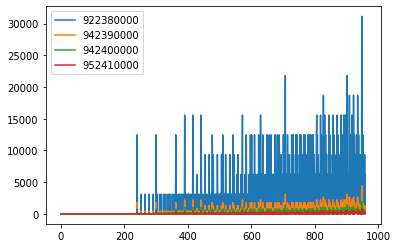

In [33]:
x = cur.execute("""SELECT time, quantity, resources.qualid, nucid, sum(quantity*massfrac) FROM
transactions inner join resources on resources.resourceid = transactions.resourceid
inner join compositions on compositions.qualid = resources.qualid
WHERE commodity='abr_in' 
group by nucid, time""").fetchall()
ww = cur.execute('SELECT DISTINCT(nucid) FROM transactions INNER JOIN resources ON resources.resourceid = transactions.resourceid INNER JOIN compositions ON compositions.qualid = resources.qualid WHERE commodity="abr_in"').fetchall()
d = {}
t = np.arange(960)
y = {q['nucid']: np.zeros(960) for q in ww}
        
for row in x:
    y[row['nucid']][row['time']] = row['sum(quantity*massfrac)']
keys = sorted(y.keys(), key=lambda i:sum(y[i]), reverse=True)[:4]
print(keys)
for key in keys:
    plt.plot(y[key], label=key)
plt.legend()

In [34]:
y[keys]

TypeError: unhashable type: 'list'

In [23]:
w = cur.execute('SELECT DISTINCT(nucid) FROM transactions inner join resources on resources.resourceid = transactions.resourceid INNER JOIN compositions on compositions.qualid = resources.qualid WHERE commodity="abr_in"').fetchall()
for row in w:
    print(row['nucid'])

360830000
420950000
430990000
440990000
441010000
441030000
441060000
451030000
451050000
451060000
461050000
461060000
461070000
461080000
471070000
471090000
481130000
491130000
491150000
501150000
511250000
521250000
521270000
531270000
531350000
541310000
541340000
541350000
541360000
551330000
551340000
551350000
551370000
561340000
561350000
561370000
581400000
601430000
601440000
601450000
611470000
611480000
611490000
621470000
621480000
621490000
621500000
621510000
621520000
621540000
631510000
631520000
631530000
631540000
631550000
641520000
641540000
641550000
641560000
641570000
641580000
661600000
661610000
661620000
661630000
661640000
671650000
681660000
681670000
802060000
812050000
812060000
812070000
812080000
812090000
812100000
822060000
822070000
822080000
822090000
822100000
822110000
822120000
822140000
832090000
832100000
832110000
832120000
832130000
832140000
832150000
842100000
842110000
842120000
842130000
842140000
842150000
842160000
842180000
852150000


In [36]:
x = cur.execute("""SELECT time, quantity, resources.qualid, nucid, sum(massfrac*quantity) FROM
Compositions LEFT OUTER JOIN Resources
ON Compositions.qualid = Resources.ResourceId
INNER JOIN Transactions ON transactions.resourceid = resources.resourceid
WHERE commodity='depu' 
group by nucid, time """).fetchall()
d = {}
for row in x:
    d[row['nucid']] = row['sum(massfrac*quantity)']

In [ ]:
x = cur.execute("""SELECT time, sum(quantity)*massfrac, nucid FROM transactions INNER JOIN resources
LEFT OUTER JOIN compositions ON compositions.qualid = resources.qualid WHERE
commodity='abr_in' GROUP BY nucid""")
d = {}
for row in x:
    d[row['nucid']] = row['sum(massfrac*quantity)']

In [ ]:
keys = sorted(d, key=d.__getitem__, reverse=True)
keys

In [31]:
t = np.arange(960)
y = {}
kk = keys[:3]
for key in kk:
    print(key)
    y[key] = np.zeros(960)
    r = [q for q in x if q['nucid'] == key]
    y[key]
    print(r)

922380000
[<sqlite3.Row object at 0x11f57ced0>, <sqlite3.Row object at 0x11f57cf70>, <sqlite3.Row object at 0x11f57cf90>, <sqlite3.Row object at 0x11f564050>]
80160000
942390000
[<sqlite3.Row object at 0x11f564450>, <sqlite3.Row object at 0x11f564530>]


In [18]:
[print(q['nucid']) for q in x]

20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
20040000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
60130000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80160000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
80170000
8

541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541310000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541320000
541330000
541330000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000
541340000


822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822100000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822110000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000
822120000


942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942410000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
942420000
952410000
952410000
952410000
952410000
952410000
952410000
952410000
952410000
952410000


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,